In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from joblib import parallel_backend

import mlflow
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from config import MLRUNS_FOLDER_PATH
from chesswinnerprediction.constants import PROCESSED_FOLDER_PATH
from chesswinnerprediction.baseline.constants import BASELINE_RANDOM_STATE
from chesswinnerprediction.baseline.utils import (
    get_x_and_y,
    get_class_weights,
    transform_and_scale_df,
    get_worst_params_df,
    estimate_baseline_model,
)

## Set the MLFlow tracking URI and experiment

In [3]:
mlflow.set_tracking_uri(MLRUNS_FOLDER_PATH)
mlflow.set_experiment(experiment_name="decision_tree")
mlflow.sklearn.autolog(disable=False)

2024/08/08 16:37:45 INFO mlflow.tracking.fluent: Experiment with name 'decision_tree' does not exist. Creating a new experiment.


## Load the data

In [4]:
data_dir = "lichess_db_standard_rated_2017-05"
data_path = os.path.join(PROCESSED_FOLDER_PATH, data_dir)

In [5]:
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
valid_df = pd.read_csv(os.path.join(data_path, "valid.csv"))

In [6]:
std_scaler = StandardScaler()
train_data = transform_and_scale_df(train_df, std_scaler)
valid_data = transform_and_scale_df(valid_df, std_scaler, fit_scaler=False)

In [7]:
X_train, y_train = get_x_and_y(train_data, predict_draws=True)
X_valid, y_valid = get_x_and_y(valid_data, predict_draws=True)

class_weight = get_class_weights(y_train)

## Apply the Decision Tree Classifier

In [8]:
random_forest_params = {
    "max_depth": [10, 11, 12],
    "max_features": [None, 0.5, "sqrt"],
    "min_samples_split": [8e-5, 1e-4, 4e-4, 8e-4, 1e-3, 4e-3],
    "min_samples_leaf": [8e-5, 1e-4, 4e-4, 8e-4, 1e-3, 4e-3, 8e-3],
    "min_impurity_decrease": [1e-6, 4e-6, 8e-6, 1e-5, 4e-5],
    "min_weight_fraction_leaf": [0.0, 1e-6, 4e-6],
    "ccp_alpha": [0.0, 1e-6, 4e-6, 8e-6, 1e-5],
    "max_leaf_nodes": [None] + [30*i for i in range(3, 6)],
}

In [9]:
tree_model = DecisionTreeClassifier(
    class_weight=class_weight, random_state=BASELINE_RANDOM_STATE
)

random_search = RandomizedSearchCV(
    estimator=tree_model,
    param_distributions=random_forest_params,
    n_iter=2,
    cv=5,
    verbose=3,
    random_state=BASELINE_RANDOM_STATE,
    scoring="balanced_accuracy",
    return_train_score=True,
    n_jobs=-1,
    refit=True,
)

In [10]:
with mlflow.start_run(run_name="random_search") as run:
    random_search_run_id = run.info.run_id
    
    with parallel_backend("multiprocessing"):
        random_search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 5/5] END ccp_alpha=0.0, max_depth=12, max_features=None, max_leaf_nodes=90, min_impurity_decrease=1e-06, min_samples_leaf=0.0004, min_samples_split=0.0008, min_weight_fraction_leaf=0.0;, score=(train=0.471, test=0.461) total time=   9.2s
[CV 1/5] END ccp_alpha=0.0, max_depth=10, max_features=None, max_leaf_nodes=90, min_impurity_decrease=4e-06, min_samples_leaf=0.004, min_samples_split=0.001, min_weight_fraction_leaf=4e-06;, score=(train=0.469, test=0.462) total time=   9.3s
[CV 2/5] END ccp_alpha=0.0, max_depth=12, max_features=None, max_leaf_nodes=90, min_impurity_decrease=1e-06, min_samples_leaf=0.0004, min_samples_split=0.0008, min_weight_fraction_leaf=0.0;, score=(train=0.467, test=0.460) total time=   9.5s
[CV 2/5] END ccp_alpha=0.0, max_depth=10, max_features=None, max_leaf_nodes=90, min_impurity_decrease=4e-06, min_samples_leaf=0.004, min_samples_split=0.001, min_weight_fraction_leaf=4e-06;, score=(train=0.467, tes

2024/08/08 16:38:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/tikhon/PycharmProjects/ChessWinnerPrediction/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/08/08 16:38:54 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


In [11]:
print(f"Best Score: {random_search.best_score_}")
print(f"Best Parameters: {random_search.best_params_}")

Best Score: 0.4618560972259328
Best Parameters: {'min_weight_fraction_leaf': 4e-06, 'min_samples_split': 0.001, 'min_samples_leaf': 0.004, 'min_impurity_decrease': 4e-06, 'max_leaf_nodes': 90, 'max_features': None, 'max_depth': 10, 'ccp_alpha': 0.0}


In [12]:
get_worst_params_df(random_search.cv_results_).head(5)

,,,,,,,,mean_test_score
param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_ccp_alpha,


## Apply the best model

In [15]:
best_forest_clf = random_search.best_estimator_

In [16]:
with mlflow.start_run(parent_run_id=random_search_run_id):
    best_forest_clf = best_forest_clf.fit(X_train, y_train)

Log Loss on test data: 1.0366
Balanced Accuracy on test data: 46.13%


                                                Classification Report
                         Train Report                                      Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.58      0.47      0.52    378005              0.57      0.47      0.52     45215
         1-0       0.63      0.35      0.45    392248              0.63      0.36      0.46     47511
     1/2-1/2       0.04      0.58      0.08     20431              0.04      0.55      0.08      2537
    accuracy                           0.42    790684                                  0.42     95263
   macro avg       0.42      0.47      0.35    790684              0.42      0.46      0.35     95263
weighted avg       0.59      0.42      0.48    790684              0.59      0.42      0.48     95263
       


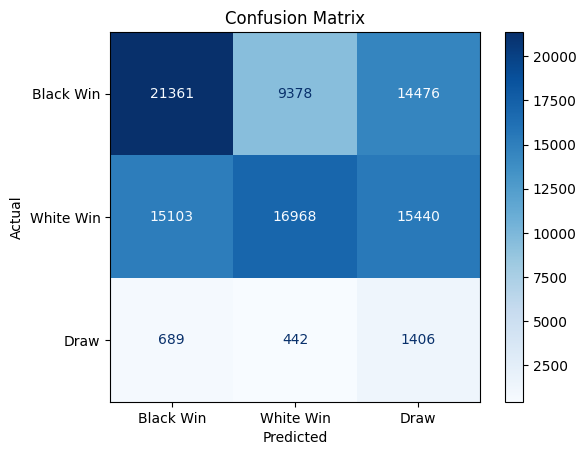

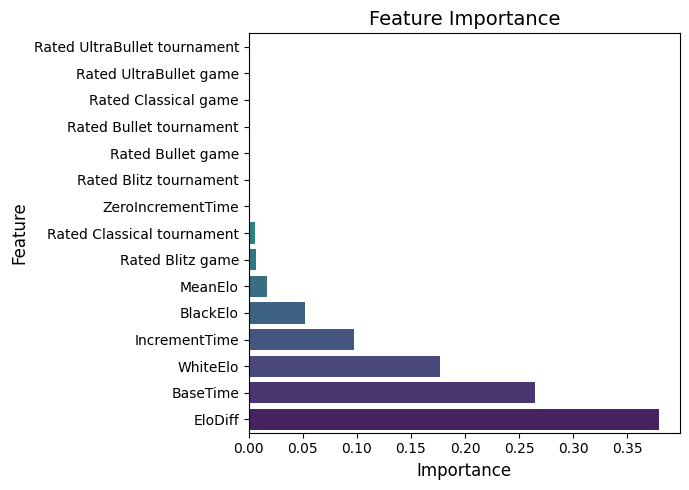

In [17]:
with mlflow.start_run(parent_run_id=random_search_run_id):
    feature_importance = [best_forest_clf.feature_importances_]
    
    estimate_baseline_model(
        best_forest_clf, feature_importance, X_train, y_train, X_valid, y_valid
    )